In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1: Read the data

In [52]:
df= pd.read_csv("/run/media/tejas/Local Disk - SSD/statistics and research/Data Analysis with Python/arima model/sales_data_sample.csv",encoding='Latin-1',parse_dates=['ORDERDATE'])


In [55]:
df = df[['ORDERDATE','SALES']]

In [56]:
df.rename(columns={'ORDERDATE':'Date'},inplace=True)

In [58]:
df.set_index('Date',inplace=True)

# Step 2: Resample
    Aggregation of Data
    Daily > monthly
    Monthly > Annualy

In [65]:
ts=df['SALES'].resample('MS').sum()

In [66]:
ts.head()

Date
2003-01-01    129753.60
2003-02-01    140836.19
2003-03-01    174504.90
2003-04-01    201609.55
2003-05-01    192673.11
Freq: MS, Name: SALES, dtype: float64

<AxesSubplot:xlabel='Date'>

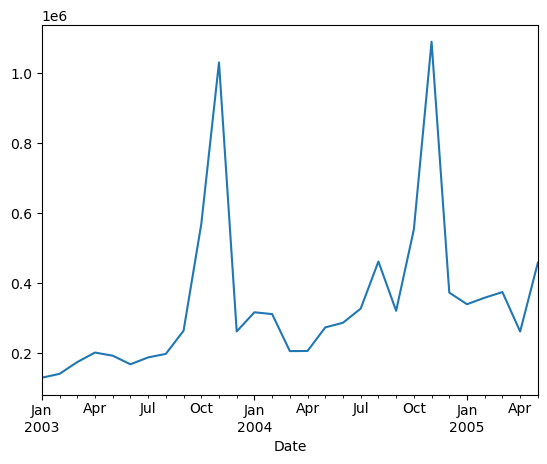

In [67]:
ts.plot()

# Step 3: Stationarity Check

In [68]:
import statsmodels.api as sm

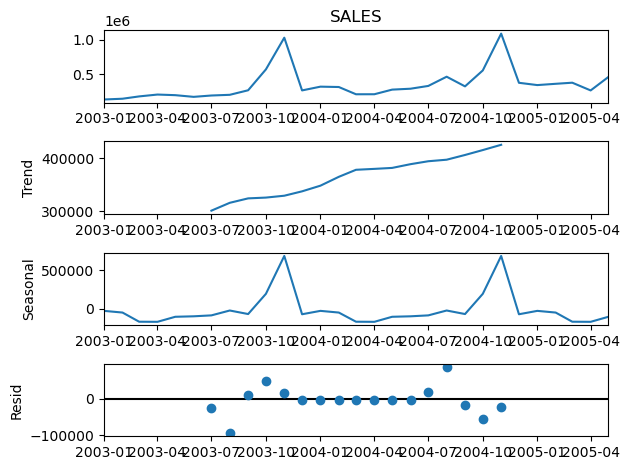

In [73]:
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

In [74]:
from statsmodels.tsa.stattools import adfuller

In [75]:
adftest = adfuller(ts)

In [77]:
print('p-value of test is: ' ,adftest[1].round(3))

p-value of test is:  0.005


# Step 4: Train test split

In [79]:
len(ts)*.8

23.200000000000003

In [80]:
train = ts[:23]
test = ts[23:]

# ARIMA MODEL BUILDING
    ARIMA has 3 componenets:
    1. AR(Atuo Regression)
    2. MA (Moving Avergae)
    3. Integrated
    
 ## For building ARIMA we need:
     AR order p
     MA order q
     Integrated order d

# Step 5: Hyerparameters of ARIMA model - p d q

## p = 5 , d= 0 , q = 4

In [82]:
#### How to get the PDQ, 3 different methods discussed below

In [85]:
from statsmodels.tsa.arima.model import ARIMA

In [160]:
model = ARIMA(train,order=(0,1,0)).fit()

   # Predict test dataset

In [161]:
import warnings
warnings.filterwarnings('ignore')

In [162]:
pred = model.predict(start=len(train),end=(len(ts)-1))

In [163]:
pred.head()

2004-12-01    1089048.01
2005-01-01    1089048.01
2005-02-01    1089048.01
2005-03-01    1089048.01
2005-04-01    1089048.01
Freq: MS, Name: predicted_mean, dtype: float64

# Step 8: Model evaluation

In [164]:
from sklearn.metrics import mean_squared_error

In [165]:
error = np.sqrt(mean_squared_error(test,pred))
error

730622.2900969628

In [166]:
test.mean(),test.std()

(360714.895, 63306.91318578651)

<AxesSubplot:xlabel='Date'>

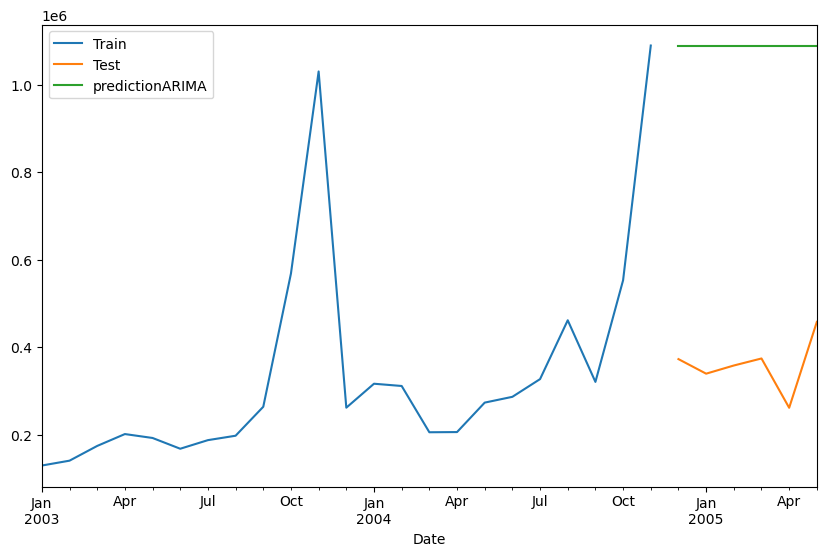

In [167]:
train.plot(legend= True, label = 'Train', figsize=(10,6))
test.plot(legend = True, label = 'Test')
pred.plot(legend = True, label = 'predictionARIMA')

# Step 9: Predict Future Data

In [168]:
final_model = ARIMA(ts, order=(5,0,4)).fit()

In [169]:
prediction = final_model.predict(len(ts),len(ts)+6)

<AxesSubplot:xlabel='Date'>

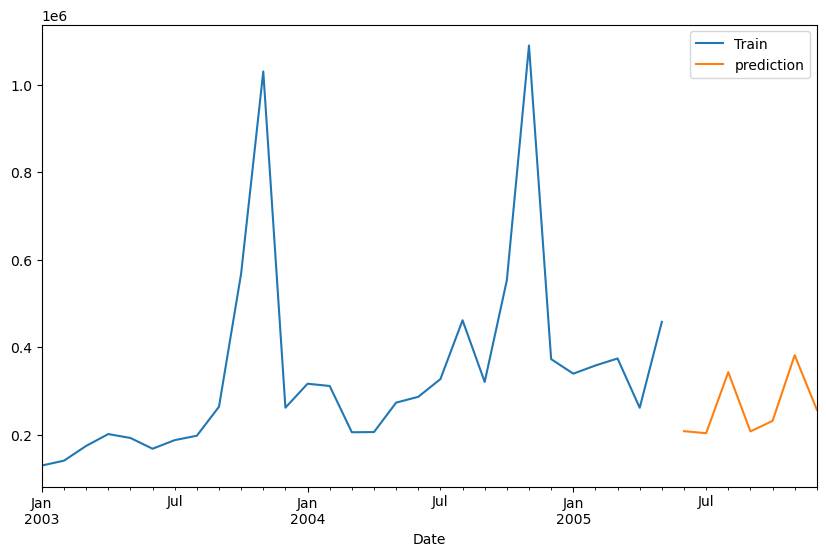

In [170]:
ts.plot(legend=True, label = 'Train',figsize = (10,6))
prediction.plot(legend = True, label = 'prediction')

### =========================================================================================

# Step 5: How to get ARIMA Hyperparameters p d q

    1. method ACF PACF plots
    2. AUTO_ARIMA function
    3. for loop

## AUTO ARIMA

In [115]:
import pmdarima
from pmdarima import auto_arima


In [141]:
auto_arima(train , m=12, start_p=0, seasonal=False, d=1,trace=True,error_action='ignore', suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=615.918, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=611.412, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=612.892, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=612.919, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=610.152, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=614.931, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.106 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### for loop

In [142]:
import itertools

In [143]:
p= range(0,8)
q= range(0,8)
d = range(0,2)

In [144]:
pdq_combination = list(itertools.product(p,d,q))

In [145]:
len(pdq_combination)

128

In [146]:
rmse = []
order1= []
for pdq in pdq_combination:
    try:
        model= ARIMA(train,order=pdq).fit()
        pred = model.predict(start=len(train),end = (len(ts)-1))
        error = np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)
    except:
        continue

In [147]:
results = pd.DataFrame(index=order1 , data = rmse, columns=['rmse'])

In [148]:
results.sort_values('rmse', ascending=False)

,rmse
"(0, 1, 0)",730622.290097
"(5, 1, 5)",677040.700647
"(1, 1, 0)",660301.710534
"(4, 0, 5)",642820.417885
"(0, 1, 1)",565288.496448
...,...
"(0, 0, 1)",134288.821663
"(1, 0, 2)",131805.679587
"(2, 1, 5)",124793.231301
"(0, 0, 0)",60714.535278
